In [64]:
import pandas as pd
import numpy as np
import time
import spacy
import random
from pathlib import Path
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchtext import data 
import torchtext
from nltk.tokenize.treebank import TreebankWordDetokenizer
import itertools
import matplotlib.pyplot as plt

In [65]:
# Setting device on GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

torch.backends.cudnn.deterministic = True

Using device: cuda

Tesla V100-SXM2-16GB
Memory Usage:
Allocated: 8.6 GB
Cached:    9.4 GB


/usr/local/lib/python3.6/dist-packages/torch/cuda/memory.py:346: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


In [66]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [67]:
TEXT = data.Field(tokenize='spacy', lower=True, include_lengths= True)
LABEL = data.LabelField(dtype=torch.float)

# Map data to fields
fields = [('target', LABEL), ('id',None),('date',None),('query',None),
      ('name',None), ('text', TEXT),('category',None)]

# Apply field definition to create torch dataset
dataset = torchtext.data.TabularDataset(
        path="/content/drive/MyDrive/Colab Notebooks/tweet_final1.csv",
        format="CSV",
        fields=fields,
        skip_header=False)



In [68]:
# Split data into train, test, validation sets
(train_data, test_data, valid_data) = dataset.split(split_ratio=[0.8,0.1,0.1])

print("Number of train data: {}".format(len(train_data)))
print("Number of test data: {}".format(len(test_data)))
print("Number of validation data: {}".format(len(valid_data)))

Number of train data: 79866
Number of test data: 9983
Number of validation data: 9983


In [94]:
cd /content/.vector_cache/

/content/.vector_cache


In [95]:
ls

lstmG-best.pt


In [96]:
from google.colab import files
files.download('lstmG-best.pt') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
rm -r /content/.vector_cache/glove.6B.zip


rm: cannot remove '/content/.vector_cache/glove.6B.zip': No such file or directory


### Build Vocabulary using GloVe


In [71]:
MAX_VOCAB_SIZE = 30000
#MAX_VOCAB_SIZE = 1193514
TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE,
                 vectors = "glove.6B.100d",
                 unk_init = torch.Tensor.normal_)

# build vocab for training set - convert words into integers
LABEL.build_vocab(train_data)

# Most frequent tokens
TEXT.vocab.freqs.most_common(10)

[('i', 49500),
 ('!', 44649),
 ('.', 39915),
 ('to', 28133),
 ('the', 26107),
 (',', 23811),
 ('a', 19042),
 ('my', 15788),
 ('you', 15232),
 ('it', 15081)]

In [72]:
BATCH_SIZE = 500

# sort_within_batch sorts all the tensors within a batch by their lengths
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    device = device,
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.text),
    sort_within_batch = True)

### Define Model

In [73]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        """
        Define the layers of the module.

        vocab_size - vocabulary size
        embedding_dim - size of the dense word vectors
        hidden_dim - size of the hidden states
        output_dim - number of classes
        n_layers - number of multi-layer RNN
        bidirectional - boolean - use both directions of LSTM
        dropout - dropout probability
        pad_idx -  string representing the pad token
        """
        
        super().__init__()

        # 1. Feed the tweets in the embedding layer
        # padding_idx set to not learn the emedding for the <pad> token - irrelevant to determining sentiment
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)

        # 2. LSTM layer
        # returns the output and a tuple of the final hidden state and final cell state
        self.encoder = nn.LSTM(embedding_dim, 
                               hidden_dim, 
                               num_layers=n_layers,
                               bidirectional=bidirectional,
                               dropout=dropout)
        
        # 3. Fully-connected layer
        # Final hidden state has both a forward and a backward component concatenated together
        # The size of the input to the nn.Linear layer is twice that of the hidden dimension size
        self.predictor = nn.Linear(hidden_dim*2, output_dim)

        # Initialize dropout layer for regularization
        self.dropout = nn.Dropout(dropout)
      
    def forward(self, text, text_lengths):
        """
        The forward method is called when data is fed into the model.

        text - [tweet length, batch size]
        text_lengths - lengths of tweet
        """

        # embedded = [sentence len, batch size, emb dim]
        embedded = self.dropout(self.embedding(text))    
        #seq_lengths_clamped = text_lengths.clamp(min=1, max=self.max_length)
        # Pack the embeddings - cause RNN to only process non-padded elements
        # Speeds up computation
        #text_lengths = torch.as_tensor(text_lengths, dtype=torch.int64, device='cpu')
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)

        # output of encoder
        packed_output, (hidden, cell) = self.encoder(packed_embedded)

        # unpack sequence - transform packed sequence to a tensor
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        # output = [sentence len, batch size, hid dim * num directions]
        # output over padding tokens are zero tensors
        
        # hidden = [num layers * num directions, batch size, hid dim]
        # cell = [num layers * num directions, batch size, hid dim]
        
        # Get the final layer forward and backward hidden states  
        # concat the final forward and backward hidden layers and apply dropout
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))

        # hidden = [batch size, hid dim * num directions]

        return self.predictor(hidden)

### Initialize the model with parameters


In [84]:
####(0.4, 100, 50, 'Adam', 0.01)

INPUT_DIM = len(TEXT.vocab)
# dim must be equal to the dim of pre-trained GloVe vectors
EMBEDDING_DIM = 100
HIDDEN_DIM = 100
OUTPUT_DIM = 1
# 2 layers of biLSTM
N_LAYERS = 2
BIDIRECTIONAL = True
# Dropout probability
DROPOUT = 0.65
# Get pad token index from vocab
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

# Create an instance of LSTM class
model = LSTM(INPUT_DIM,
            EMBEDDING_DIM,
            HIDDEN_DIM,
            OUTPUT_DIM,
            N_LAYERS,
            BIDIRECTIONAL,
            DROPOUT,
            PAD_IDX)

In [85]:
pretrained_embeddings = TEXT.vocab.vectors

# [vocab size, embedding dim]
print(pretrained_embeddings.shape)

torch.Size([30002, 100])


In [86]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-1.0091, -1.4946,  1.9278,  ...,  1.5485, -1.6035,  1.1188],
        [ 0.4502,  0.4447,  0.8942,  ...,  0.0841,  2.3011,  0.6857],
        [-0.0465,  0.6197,  0.5665,  ..., -0.3762, -0.0325,  0.8062],
        ...,
        [ 0.8057,  0.9971, -0.5410,  ..., -3.4178, -1.3525, -0.3790],
        [ 1.3994,  0.4356, -0.6494,  ..., -0.1006, -0.3234, -1.9785],
        [ 0.1735,  0.0984,  0.1979,  ..., -0.4334,  0.3016,  0.4964]])

In [87]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

# Setting row in the embedding weights matrix to zero using the token index
model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0465,  0.6197,  0.5665,  ..., -0.3762, -0.0325,  0.8062],
        ...,
        [ 0.8057,  0.9971, -0.5410,  ..., -3.4178, -1.3525, -0.3790],
        [ 1.3994,  0.4356, -0.6494,  ..., -0.1006, -0.3234, -1.9785],
        [ 0.1735,  0.0984,  0.1979,  ..., -0.4334,  0.3016,  0.4964]])


In [88]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.RMSprop(model.parameters(),lr=0.001)

# Loss function: binary cross entropy with logits
# It restricts the predictions to a number between 0 and 1 using the logit function
# then use the bound scarlar to calculate the loss using binary cross entropy
criterion = nn.BCEWithLogitsLoss()

# Use GPU
model = model.to(device)
criterion = criterion.to(device)

In [79]:
def batch_accuracy(predictions, label):
    """
    Returns accuracy per batch.

    predictions - float
    label - 0 or 1
    """

    # Round predictions to the closest integer using the sigmoid function
    preds = torch.round(torch.sigmoid(predictions))
    # If prediction is equal to label
    correct = (preds == label).float()
    # Average correct predictions
    accuracy = correct.sum() / len(correct)

    return accuracy

def timer(start_time, end_time):
    """
    Returns the minutes and seconds.
    """

    time = end_time - start_time
    mins = int(time / 60)
    secs = int(time - (mins * 60))

    return mins, secs

In [80]:
def train(model, iterator, optimizer, criterion):
        
    # Cumulated Training loss
    training_loss = 0.0
    # Cumulated Training accuracy
    training_acc = 0.0
    
    # Set model to training mode
    model.train()
    
    # For each batch in the training iterator
    for batch in iterator:
        
        # 1. Zero the gradients
        optimizer.zero_grad()
        
        # batch.text is a tuple (tensor, len of seq)
        text, text_lengths = batch.text
        text_lengths = torch.as_tensor(text_lengths, dtype=torch.int64, device='cpu')
        
        # 2. Compute the predictions
        predictions = model(text, text_lengths).squeeze(1)
        
        # 3. Compute loss
        loss = criterion(predictions, batch.target)
        
        # Compute accuracy
        accuracy = batch_accuracy(predictions, batch.target)
        
        # 4. Use loss to compute gradients
        loss.backward()
        
        # 5. Use optimizer to take gradient step
        optimizer.step()
        
        training_loss += loss.item()
        training_acc += accuracy.item()
    
    # Return the loss and accuracy, averaged across each epoch
    # len of iterator = num of batches in the iterator
    return training_loss / len(iterator), training_acc / len(iterator)

In [81]:
def evaluate(model, iterator, criterion):
    """
    Function to evaluate the loss and accuracy of validation and test sets.

    iterator - validation or test iterator
    """
    
    # Cumulated Training loss
    eval_loss = 0.0
    # Cumulated Training accuracy
    eval_acc = 0
    
    # Set model to evaluation mode
    model.eval()
    
    # Don't calculate the gradients
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.text
            text_lengths = torch.as_tensor(text_lengths, dtype=torch.int64, device='cpu')
            
            predictions = model(text, text_lengths).squeeze(1)
            
            loss = criterion(predictions, batch.target)
            
            accuracy = batch_accuracy(predictions, batch.target)

            eval_loss += loss.item()
            eval_acc += accuracy.item()
        
    return eval_loss / len(iterator), eval_acc / len(iterator)

In [21]:
##Grid Search to find best hyperparameters

GRID_DROPOUT = [.5, .75, .4]
HIDDEN_DIM = [64,100,256]
GRID_EMBED_DIM = [50,100,300]
GRID_OPT_SELECT = ["Adam","RMSprop"]
#GRID_LR = [0.01,0.001,0.0001]
GRID_LR = [0.1,0.01,0.001]

GRID_TOTAL = [] 

for perm in itertools.product(GRID_DROPOUT, HIDDEN_DIM, GRID_EMBED_DIM, GRID_OPT_SELECT, GRID_LR):
    GRID_TOTAL.append(perm)

len(GRID_TOTAL) ## 162 models
GRID_MODELS = []
GRID_OPT = []

for i in range(len(GRID_TOTAL)):
    
    DROPOUT = GRID_TOTAL[i][0]
    HIDDEN_DIM = GRID_TOTAL[i][1]
    GRID_EMBED_DIM = GRID_TOTAL[i][2]
    OPT = GRID_TOTAL[i][3]
    LR = GRID_TOTAL[i][4]
    
    GRID_MODELS.append(LSTM(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX).to(device))
    GRID_OPT.append(eval("optim."+OPT)(GRID_MODELS[i].parameters(),LR))

In [32]:
NUM_EPOCHS = 10
GRID_TRACKER = []
Val_Tracker = []
best_valid_loss = float('inf')
for i in range(len(GRID_MODELS)):
  print("Params", GRID_MODELS[i].parameters)
  for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    criterion = nn.BCEWithLogitsLoss()
    criterion.to(device)
    train_loss, train_acc = train(GRID_MODELS[i], train_iterator, GRID_OPT[i], criterion)
    valid_loss, valid_acc = evaluate(GRID_MODELS[i], valid_iterator, criterion)
    # Save val_acc
    Val_Tracker.append(valid_acc)
       
    end_time = time.time()
    mins, secs = timer(start_time,end_time)
    print("Epoch {}:".format(epoch+1))
    print(GRID_MODELS[i])
    #print(GRID_TOTAL[GRID_TRACKER.index(np.max(GRID_TRACKER))])
    print("\t Total Time: {}m {}s".format(mins, secs))
    print("\t Train Loss {} | Train Accuracy: {}%".format(round(train_loss, 2), round(train_acc*100, 2)))
    print("\t Validation Loss {} | Validation Accuracy: {}%".format(round(valid_loss, 2), round(valid_acc*100, 2)))
  GRID_TRACKER.append(np.max([Val_Tracker[x] for x in range(len(Val_Tracker))]))


Streaming output truncated to the last 5000 lines.
  (embedding): Embedding(30002, 100, padding_idx=1)
  (encoder): LSTM(100, 64, num_layers=2, dropout=0.4, bidirectional=True)
  (predictor): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)
	 Total Time: 0m 3s
	 Train Loss 0.73 | Train Accuracy: 50.7%
	 Validation Loss 0.72 | Validation Accuracy: 49.92%
Epoch 10:
LSTM(
  (embedding): Embedding(30002, 100, padding_idx=1)
  (encoder): LSTM(100, 64, num_layers=2, dropout=0.4, bidirectional=True)
  (predictor): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)
	 Total Time: 0m 2s
	 Train Loss 0.73 | Train Accuracy: 50.61%
	 Validation Loss 0.7 | Validation Accuracy: 53.56%
Params <bound method Module.parameters of LSTM(
  (embedding): Embedding(30002, 100, padding_idx=1)
  (encoder): LSTM(100, 64, num_layers=2, dropout=0.4, bidirectional=True)
  (predictor): Linear(in_features=128, out_features=1, 

In [33]:
####(0.4, 100, 50, 'Adam', 0.001)
GRID_TOTAL[GRID_TRACKER.index(np.max(GRID_TRACKER))] 
np.max(GRID_TRACKER)
print(GRID_TOTAL[GRID_TRACKER.index(np.max(GRID_TRACKER))])

print("mean: %f and std dev: %f " % (np.mean(GRID_TRACKER), np.std(GRID_TRACKER)))

(0.4, 100, 50, 'Adam', 0.001)
mean: 0.806755 and std dev: 0.021972 


In [49]:
GRID_TRACKER.index(np.max(GRID_TRACKER))
len(GRID_TRACKER)

162

In [82]:
def training_plot(epoch_num, train_loss_list, train_acc_list, valid_loss_list, valid_acc_list):
    plt.figure()
    plt.plot(range(epoch_num), train_loss_list, color='blue', linestyle='-', label='train_loss')
    plt.plot(range(epoch_num), valid_loss_list, color='green', linestyle='--', label='val_loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Training and validation loss')
    plt.grid()
    plt.show()

    plt.figure()
    plt.plot(range(epoch_num), train_acc_list, color='blue', linestyle='-', label='train_acc')
    plt.plot(range(epoch_num), valid_acc_list, color='green', linestyle='--', label='val_acc')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.title('Training and validation accuracy')
    plt.grid()
    plt.show()

Epoch 1:
	 Total Time: 0m 3s
	 Train Loss 0.62 | Train Accuracy: 64.45%
	 Validation Loss 0.53 | Validation Accuracy: 73.74%
Epoch 2:
	 Total Time: 0m 3s
	 Train Loss 0.55 | Train Accuracy: 71.99%
	 Validation Loss 0.49 | Validation Accuracy: 77.2%
Epoch 3:
	 Total Time: 0m 3s
	 Train Loss 0.51 | Train Accuracy: 75.05%
	 Validation Loss 0.46 | Validation Accuracy: 78.41%
Epoch 4:
	 Total Time: 0m 3s
	 Train Loss 0.49 | Train Accuracy: 76.68%
	 Validation Loss 0.45 | Validation Accuracy: 78.8%
Epoch 5:
	 Total Time: 0m 3s
	 Train Loss 0.47 | Train Accuracy: 77.62%
	 Validation Loss 0.45 | Validation Accuracy: 79.34%
Epoch 6:
	 Total Time: 0m 3s
	 Train Loss 0.46 | Train Accuracy: 78.78%
	 Validation Loss 0.44 | Validation Accuracy: 79.69%
Epoch 7:
	 Total Time: 0m 3s
	 Train Loss 0.45 | Train Accuracy: 79.23%
	 Validation Loss 0.44 | Validation Accuracy: 79.94%
Epoch 8:
	 Total Time: 0m 3s
	 Train Loss 0.44 | Train Accuracy: 79.97%
	 Validation Loss 0.44 | Validation Accuracy: 79.97%
Ep

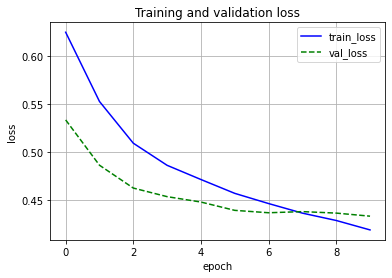

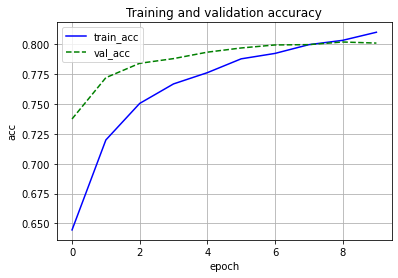

In [89]:
# Number of epochs
NUM_EPOCHS = 10

# Lowest validation lost
best_valid_loss = float('inf')
train_loss_list = []
train_acc_list  = []
valid_loss_list = []
valid_acc_list  = []

for epoch in range(NUM_EPOCHS):

    start_time = time.time()
    
    # Evaluate training loss and accuracy
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    # Evaluate validation loss and accuracy
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    mins, secs = timer(start_time, end_time)
    
    # At each epoch, if the validation loss is the best
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        # Save the parameters of the model
        torch.save(model.state_dict(), 'lstmG-best.pt')

    print("Epoch {}:".format(epoch+1))
    print("\t Total Time: {}m {}s".format(mins, secs))
    print("\t Train Loss {} | Train Accuracy: {}%".format(round(train_loss, 2), round(train_acc*100, 2)))
    print("\t Validation Loss {} | Validation Accuracy: {}%".format(round(valid_loss, 2), round(valid_acc*100, 2)))

    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc)

training_plot(NUM_EPOCHS, train_loss_list, train_acc_list, valid_loss_list, valid_acc_list)

In [90]:
# Load the model with the best validation loss
model.load_state_dict(torch.load('lstmG-best.pt'))

# Evaluate test loss and accuracy
test_loss, test_acc = evaluate(model, test_iterator, criterion)

print("Test Loss: {} | Test Acc: {}%".format(round(test_loss, 2), round(test_acc*100, 2)))

Test Loss: 0.44 | Test Acc: 79.88%


In [91]:
nlp = spacy.load('en')

def predict(model, text, tokenized=True):
    """
    Given a tweet, predict the sentiment.

    text - a string or a a list of tokens
    tokenized - True if text is a list of tokens, False if passing in a string
    """

    # Sets the model to evaluation mode
    model.eval()

    if tokenized == False:
        # Tokenizes the sentence
        tokens = [token.text for token in nlp.tokenizer(text)]
    else:
        tokens = text

    # Index the tokens by converting to the integer representation from the vocabulary
    indexed_tokens = [TEXT.vocab.stoi[t] for t in tokens]
    # Get the length of the text
    length = [len(indexed_tokens)]
    # Convert the indices to a tensor
    tensor = torch.LongTensor(indexed_tokens).to(device)
    # Add a batch dimension by unsqueezeing
    tensor = tensor.unsqueeze(1)
    # Converts the length into a tensor
    length_tensor = torch.LongTensor(length)
    # Convert prediction to be between 0 and 1 with the sigmoid function
    prediction = torch.sigmoid(model(tensor, length_tensor))

    # Return a single value from the prediction
    return prediction.item()

In [92]:
print("Tweet: {}".format(TreebankWordDetokenizer().detokenize(test_data[20].text)))

print("Prediction: {}".format(round(predict(model, test_data[20].text), 2)))

print("True Label: {}".format(test_data[10].target))

Tweet: yeah chris!!!!! i don't know why i couldn't find you when i did a search...but thanks for following me
Prediction: 0.38
True Label: 0


In [93]:
# List to append data to
d = []


for idx in range(10):

    # Detokenize the tweets from the test set
    tweet = TreebankWordDetokenizer().detokenize(test_data[idx].text)
                                                 
    # Append tweet, prediction, and true label
    d.append({'Tweet': tweet, 'Prediction': predict(model, test_data[idx].text), 'True Label': test_data[idx].target})

# Convert list to dataframe
pd.DataFrame(d)

,Tweet,Prediction,True Label
0,i miss my long hair.,0.017848,0
1,congrat's anjel! * hugs *,0.833750,1
2,yea,0.637666,0
3,my phone is dead,0.029038,0
4,gonna go & work on some & quot;pen assignment ...,0.950301,1
5,dude can i use that? thx!,0.959712,1
6,morning tony.a bit dull down here today hopefu...,0.568400,0
7,my nephue typed that i love him.,0.902547,1
8,i wish true life was on,0.041251,0
9,ahh thankyou x,0.951210,1
